# ML for Bioinformatics
## HW6 - Variational Autoencoder

---

Name: Monireh Safari

Student No.: 98201803

---
do not forget to insert your Name and Student No. in this cell !!!!

#import library and setting device

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm.auto import tqdm, trange
import math
%matplotlib inline

In [40]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
  device = torch.device("cpu")
  print("Running on the CPU")

Running on the GPU


#loading Data
The MNIST database of handwritten digits contain diffrents images of digits. 

similar to MNIST,fashionMNIST is dataset containg 10 type of clothes instead of 10 type of digits. 

for example label 0 in MNIST is for 0 digit and 0 in FashionMNIST is for T-shirt. all the images is gray-scale and 28*28.

for more information you can visit this [link](https://github.com/zalandoresearch/fashion-mnist) 

In [41]:
# Get MNIST dataloader
BATCH_SIZE = 128
data_loader_kwargs = {
    'batch_size': BATCH_SIZE, 
    'shuffle': True,
    'pin_memory': True,
    'num_workers': 4,
}
train_dataset = None
test_dataset = None
train_loader = None
test_loader = None
############################## P1 ##############################
# in this cell first download the fashionMNIST dataset         #
# for train (use toTensor transform and download = True)       #
# and put it in train_dataset. then get test dataset          #
# and put it in test_dataset(no need to download again).       #
# then make train and test loader using the data_loader_kwargs #
################################################################
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True )
test_dataset = datasets.FashionMNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True )
train_loader = torch.utils.data.DataLoader(
    train_dataset, **data_loader_kwargs)
test_loader = torch.utils.data.DataLoader(
    test_dataset, **data_loader_kwargs)
######################## end #########################


#Auto-Encoder

In [42]:
class AE(nn.Module):
    def __init__(self, input_dim, encoder_dims, z_dim, decoder_dims):
        super(AE, self).__init__()
        # input_dim = is the dimension of your input
        # encoder_dims = is list containing of some integer that shows the dimension of encoder layers, between input layer and latent layer  
        # z_dim = dimension of latent layer
        # decoder_dims = is list containing of some integer that shows the dimension of decoder layers, between latent layer and output layer (same as input_dim)  
        self.type_str = 'AE'
        self.z_dim = z_dim
        self.dropout = nn.Dropout(p=0.2)
        encoder_layers = list()
        ####################### P2 ###############################
        # Iterate over `encoder_dims` and create fully connected #
        # layers using nn.Linear. Use ReLU activation function   #   
        # after each FC layer using nn.ReLU Append all layers to #
        #`encoder_layers`.                                       #
        ##########################################################
        encoder_hidden_layer0 = nn.Linear(in_features=input_dim, out_features=encoder_dims[0])
        encoder_layers.append(encoder_hidden_layer0)
        encoder_layers.append(nn.ReLU()) 
        for d in range(1,len(encoder_dims)):
          encoder_layers.append(nn.Linear(in_features = encoder_dims[d - 1], out_features = encoder_dims[d]))
          encoder_layers.append(nn.ReLU()) 
        ####################### End ########################
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Compute Z
        self.z_layer = None
        ########################  P3 #############################
        # Define a fully connected layer that maps the output of #
        # previous part to `z_dim` dimensions, store it in       #
        # `self.z_layer`. No activation function is needed after #
        # this layer.                                            #
        ##########################################################
        ######################## End #############################
        self.z_layer = nn.Linear(in_features = encoder_dims[d], out_features = self.z_dim)
        # Decoder part
        decoder_layers = list()
        ########################## P4 ###############################
        # Define the decoder part (Use `decoder_dims`)              #
        # Use ReLU activation function after each FC layer          # 
        # (except the last one).The last layer output should be     #
        # of `input_dim` size. Append all layers to `decoder_layers`#
        #############################################################
        decoder_hidden_layer0 = nn.Linear(in_features=self.z_dim, out_features=decoder_dims[0])
        decoder_layers.append(decoder_hidden_layer0)
        decoder_layers.append(nn.ReLU()) 
        for d in range(1,len(decoder_dims)):
          decoder_layers.append(nn.Linear(in_features = decoder_dims[d - 1], out_features = decoder_dims[d]))
          decoder_layers.append(nn.ReLU()) 
        
        decoder_layers.append(nn.Linear(in_features = decoder_dims[d], out_features = input_dim))
       
        ####################### End ##################################
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x_hat, z = None, None
        dropped_out = self.dropout(x)
        ################ P5 #######################
        # Do the forward pass                     #
        # use dropped_out instead of x            #
        # Compute `x_hat` (reconstructed inputs), #
        # and `z` (the latent variables)          #
        ########################################### 
        encoder_out_put = self.encoder(dropped_out)
        z = self.z_layer(encoder_out_put)
        x_hat = self.decoder(z)
        ####################### End ###############
        return x_hat, z, None 

    def get_loss(self, x, x_hat, *_):
        ########### P6 ############
        # Compute and return the  #
        # MSE between x and x_hat #
        ###########################  
        # return np.square(np.subtract(x,x_hat)).mean()
        loss = nn.MSELoss()
        output = loss(x, x_hat)
        return output
        ########### End ###########

# train and test functions
in the following cells we enumerate on datasets and on each batch, first we flatten 28*28 image to 784 and then giving this to forward pass of our model. then by computing loss and running backprop on loss we can have all the gradients. then by calling optimizer.step() we update all the parameters.
in test function we find loss and report that.


In [43]:
LOG_INTERVAL = 200
def train(model, optimizer, verbose=True):
    """
    This function trains a `model` on `train_loader` for 1 epoch and prints the
    loss value
    """
    model.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(tqdm(train_loader, desc='Batches', leave=False)):
        x = x.flatten(start_dim=1).to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = model(x)
        loss = model.get_loss(x, x_hat, mu, logvar)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if verbose and batch_idx % LOG_INTERVAL == LOG_INTERVAL-1:
            print('    Train [%d/%d]\t | \tLoss: %.5f' % (batch_idx * x.shape[0], len(train_loader.dataset), loss.item() / x.shape[0]))
    train_loss /= len(train_loader.dataset)
    if verbose:
        print('==> Train | Average loss: %.4f' % train_loss)

In [44]:
def test(model, verbose=True):
    """
    This function tests a `model` on a `test_loader` and prints the loss value
    """
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for x, _ in test_loader:
            x = x.flatten(start_dim=1).to(device)
            x_hat, mu, logvar = model(x)
            loss = model.get_loss(x, x_hat, mu, logvar)
            test_loss += loss.item()

    test_loss /= len(test_loader.dataset)
    if verbose:
        print('==> Test  | Average loss: %.4f' % test_loss)

In [45]:
def run(model, n_epoch, verbose=True):
    """
    This function will optimize parameters of `model` for `n_epoch` epochs
    on `train_loader` and validate it on `test_loader`.
    """
    LEARNING_RATE = 5e-5
    ###################### P7 ################################
    # Send `model` to the desired device, defined in `device`#
    ##########################################################
    model = model.to(device)
    ####################### End ##############################

    optimizer = None
    ################## P8 #####################
    # Initialize a new Adam optimizer         #
    ###########################################
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    ################## End ####################

    for epoch in trange(1, n_epoch+1, desc='Epochs', leave=True):
        if verbose:
            print('\nEpoch %d:' % epoch)
        train(model, optimizer, verbose)
        test(model, verbose)

In [46]:
#run this cell to train model and report loss on test dataset
ae = AE(28*28, [512,128,64], 30, [64,128,512])
run(ae,50)


Epoch 1:


    Train [25472/60000]	 | 	Loss: 0.00052
    Train [51072/60000]	 | 	Loss: 0.00033
==> Train | Average loss: 0.0006
==> Test  | Average loss: 0.0003

Epoch 2:


    Train [25472/60000]	 | 	Loss: 0.00028
    Train [51072/60000]	 | 	Loss: 0.00027
==> Train | Average loss: 0.0003
==> Test  | Average loss: 0.0002

Epoch 3:


    Train [25472/60000]	 | 	Loss: 0.00022
    Train [51072/60000]	 | 	Loss: 0.00021
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 4:


    Train [25472/60000]	 | 	Loss: 0.00019
    Train [51072/60000]	 | 	Loss: 0.00018
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 5:


    Train [25472/60000]	 | 	Loss: 0.00020
    Train [51072/60000]	 | 	Loss: 0.00018
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 6:


    Train [25472/60000]	 | 	Loss: 0.00018
    Train [51072/60000]	 | 	Loss: 0.00019
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 7:


    Train [25472/60000]	 | 	Loss: 0.00018
    Train [51072/60000]	 | 	Loss: 0.00018
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 8:


    Train [25472/60000]	 | 	Loss: 0.00018
    Train [51072/60000]	 | 	Loss: 0.00017
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 9:


    Train [25472/60000]	 | 	Loss: 0.00017
    Train [51072/60000]	 | 	Loss: 0.00018
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 10:


    Train [25472/60000]	 | 	Loss: 0.00016
    Train [51072/60000]	 | 	Loss: 0.00017
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 11:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00017
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 12:


    Train [25472/60000]	 | 	Loss: 0.00017
    Train [51072/60000]	 | 	Loss: 0.00017
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 13:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00016
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 14:


    Train [25472/60000]	 | 	Loss: 0.00016
    Train [51072/60000]	 | 	Loss: 0.00016
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 15:


    Train [25472/60000]	 | 	Loss: 0.00016
    Train [51072/60000]	 | 	Loss: 0.00017
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0002

Epoch 16:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0001

Epoch 17:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00017
==> Train | Average loss: 0.0002
==> Test  | Average loss: 0.0001

Epoch 18:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 19:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 20:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00016
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 21:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 22:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 23:


    Train [25472/60000]	 | 	Loss: 0.00016
    Train [51072/60000]	 | 	Loss: 0.00015
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 24:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 25:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 26:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 27:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 28:


    Train [25472/60000]	 | 	Loss: 0.00015
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 29:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 30:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 31:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 32:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 33:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 34:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 35:


    Train [25472/60000]	 | 	Loss: 0.00012
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 36:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 37:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 38:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 39:


    Train [25472/60000]	 | 	Loss: 0.00012
    Train [51072/60000]	 | 	Loss: 0.00014
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 40:


    Train [25472/60000]	 | 	Loss: 0.00012
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 41:


    Train [25472/60000]	 | 	Loss: 0.00014
    Train [51072/60000]	 | 	Loss: 0.00012
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 42:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 43:


    Train [25472/60000]	 | 	Loss: 0.00012
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 44:


    Train [25472/60000]	 | 	Loss: 0.00012
    Train [51072/60000]	 | 	Loss: 0.00012
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 45:


    Train [25472/60000]	 | 	Loss: 0.00012
    Train [51072/60000]	 | 	Loss: 0.00012
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 46:


    Train [25472/60000]	 | 	Loss: 0.00012
    Train [51072/60000]	 | 	Loss: 0.00013
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 47:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00012
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 48:


    Train [25472/60000]	 | 	Loss: 0.00013
    Train [51072/60000]	 | 	Loss: 0.00012
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 49:


    Train [25472/60000]	 | 	Loss: 0.00012
    Train [51072/60000]	 | 	Loss: 0.00012
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001

Epoch 50:


    Train [25472/60000]	 | 	Loss: 0.00012
    Train [51072/60000]	 | 	Loss: 0.00012
==> Train | Average loss: 0.0001
==> Test  | Average loss: 0.0001



In [55]:
def show(images, rows=2):
    """
    This function gets multiple MNIST images and plots them in the given number
    of rows.
    """
    # print(images.shape)
    if images.shape[-1] == 784 or images.shape[1] == 1:
        images = images.reshape(-1, 28, 28)
    ########################### P9 #############################
    # calculate the #cols that we need and then plot images in #
    # appropriate #cols and #rows                              #
    ############################################################
    
    n_image = images.shape[0]
    cols = math.floor(n_image / rows)
    fig, axes = plt.subplots(rows, cols, figsize=(2*cols,2*rows))
    for i in range(n_image):
        ax = axes[i//cols, i%cols]
        ax.imshow(images[i])
    plt.tight_layout()
    plt.show()
    ############################ end ###########################

#VAE
now similar to auto encoder we want to make class that inherit from AE class and implement VAE

In [48]:
class VAE(AE):
    def __init__(self, input_dim, encoder_dims, z_dim, decoder_dims):
        super(VAE, self).__init__(input_dim, encoder_dims, z_dim, decoder_dims)
        
        self.type_str = 'VAE'
        del self.z_layer  # z_layer is not needed anymore
        # Drouput, Encoder, and Decoder have been defined in AE class
        self.input_dim = input_dim
        # mu and sigma_matrix part
        self.mu_layer, self.logvar_layer = None, None
        ############################# P10 #############################
        # Define mu and logvar layers                                 #
        # Notice that we should have a logvar_layer, not a sigma_layer#
        # Do not use any activation function                          #
        ###############################################################
        self.mu_layer = nn.Linear(in_features = encoder_dims[-1], out_features = self.z_dim)
        self.logvar_layer = nn.Linear(in_features = encoder_dims[-1], out_features = self.z_dim) 
        ############################## End ############################

    # @staticmethod
    def reparameterize(self, mu, logvar):
        z = None
        ############################### P11 #################################
        # Sample `z` from N(`mu`, e^`logvar`) in a way that the gradient can#
        # backpropagate through this sampling operation                     #
        #####################################################################
        # std = torch.exp(logvar)
        # eps = torch.randn_like(std)
        # z =  eps.mul(std).add_(mu)
        if self.training:
            std = torch.exp(logvar)
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

        ############################### End ##################################
        # return z

    def forward(self, x):
        x_hat, mu, logvar = None, None, None
        dropped_out = self.dropout(x)
        ################################# P12 ####################################
        # Do the forward pass                                                    #
        # Compute `x_hat` (reconstructed inputs), `mu`, and `logvar` (outputs of #
        # `mu_layer` and `logvar_layer` respectively)                            #
        # Use reparameterization trick (the function you have implemented)       #
        ##########################################################################
        encoder_out_put = self.encoder(dropped_out)
        logvar = self.logvar_layer(encoder_out_put)
        mu = self.mu_layer(encoder_out_put)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        ################################### End ###################################
        return x_hat, mu, logvar
    
    def get_loss(self, x, x_hat, mu, logvar):
        MSE, KLD = 0, 0
        ################################## P13 ######################################
        # Compute the VAE loss (Assuming Guassian distribution for the decoder      #
        # output)                                                                   #
        #############################################################################
        KLD = torch.mean(1 + logvar - mu.pow(2) - logvar.exp()) * -0.5
        loss2 = nn.MSELoss()
        MSE = torch.mean(loss2(x, x_hat))
        MSE = MSE * self.input_dim * self.input_dim

        ################################## End ######################################
        return KLD + MSE

    def generate(self, n):
        samples = None
        ################################## P14 ##################################
        # Generate `n` random noises from N(0, I), feed it into the decoder and #
        # generate `n` samples                                                  #
        #########################################################################
        m = torch.distributions.normal.Normal(0,1)
        noise = m.sample([n,AE.z_dim])
        samples = self.decoder(noise)
        ################################### End #################################
        return samples

#Training VAE
using the functions from last part we can train our VAE model and see the loss on train and test datasets

In [49]:
vae = VAE(28*28, [512,128,64], 30, [64,128,512])
run(vae,50)



Epoch 1:


    Train [25472/60000]	 | 	Loss: 341.52979
    Train [51072/60000]	 | 	Loss: 316.99814
==> Train | Average loss: 426.4895
==> Test  | Average loss: 274.6873

Epoch 2:


    Train [25472/60000]	 | 	Loss: 193.46979
    Train [51072/60000]	 | 	Loss: 195.94623
==> Train | Average loss: 207.6449
==> Test  | Average loss: 182.1074

Epoch 3:


    Train [25472/60000]	 | 	Loss: 174.76276
    Train [51072/60000]	 | 	Loss: 154.98808
==> Train | Average loss: 166.3382
==> Test  | Average loss: 153.2004

Epoch 4:


    Train [25472/60000]	 | 	Loss: 144.81277
    Train [51072/60000]	 | 	Loss: 142.66866
==> Train | Average loss: 142.8535
==> Test  | Average loss: 132.4748

Epoch 5:


    Train [25472/60000]	 | 	Loss: 126.70509
    Train [51072/60000]	 | 	Loss: 130.25436
==> Train | Average loss: 128.5095
==> Test  | Average loss: 124.0476

Epoch 6:


    Train [25472/60000]	 | 	Loss: 125.11493
    Train [51072/60000]	 | 	Loss: 117.36980
==> Train | Average loss: 122.3587
==> Test  | Average loss: 119.4183

Epoch 7:


    Train [25472/60000]	 | 	Loss: 115.96916
    Train [51072/60000]	 | 	Loss: 116.65606
==> Train | Average loss: 117.8017
==> Test  | Average loss: 114.9007

Epoch 8:


    Train [25472/60000]	 | 	Loss: 118.87819
    Train [51072/60000]	 | 	Loss: 118.08964
==> Train | Average loss: 114.0492
==> Test  | Average loss: 111.2766

Epoch 9:


    Train [25472/60000]	 | 	Loss: 112.00440
    Train [51072/60000]	 | 	Loss: 101.64771
==> Train | Average loss: 110.8257
==> Test  | Average loss: 108.1011

Epoch 10:


    Train [25472/60000]	 | 	Loss: 111.17233
    Train [51072/60000]	 | 	Loss: 111.27877
==> Train | Average loss: 107.5391
==> Test  | Average loss: 104.6975

Epoch 11:


    Train [25472/60000]	 | 	Loss: 105.24489
    Train [51072/60000]	 | 	Loss: 102.25120
==> Train | Average loss: 104.5064
==> Test  | Average loss: 101.6120

Epoch 12:


    Train [25472/60000]	 | 	Loss: 104.11652
    Train [51072/60000]	 | 	Loss: 101.49096
==> Train | Average loss: 101.8189
==> Test  | Average loss: 99.5469

Epoch 13:


    Train [25472/60000]	 | 	Loss: 100.77971
    Train [51072/60000]	 | 	Loss: 101.73081
==> Train | Average loss: 99.4406
==> Test  | Average loss: 97.2198

Epoch 14:


    Train [25472/60000]	 | 	Loss: 100.35392
    Train [51072/60000]	 | 	Loss: 99.02826
==> Train | Average loss: 97.4935
==> Test  | Average loss: 94.9985

Epoch 15:


    Train [25472/60000]	 | 	Loss: 98.27885
    Train [51072/60000]	 | 	Loss: 89.53542
==> Train | Average loss: 95.8163
==> Test  | Average loss: 93.4439

Epoch 16:


    Train [25472/60000]	 | 	Loss: 92.48727
    Train [51072/60000]	 | 	Loss: 78.71831
==> Train | Average loss: 94.2987
==> Test  | Average loss: 91.7850

Epoch 17:


    Train [25472/60000]	 | 	Loss: 85.16309
    Train [51072/60000]	 | 	Loss: 86.63334
==> Train | Average loss: 92.9376
==> Test  | Average loss: 90.3645

Epoch 18:


    Train [25472/60000]	 | 	Loss: 94.52271
    Train [51072/60000]	 | 	Loss: 81.32629
==> Train | Average loss: 91.6954
==> Test  | Average loss: 89.1635

Epoch 19:


    Train [25472/60000]	 | 	Loss: 89.44535
    Train [51072/60000]	 | 	Loss: 86.69551
==> Train | Average loss: 90.5546
==> Test  | Average loss: 88.2080

Epoch 20:


    Train [25472/60000]	 | 	Loss: 89.26555
    Train [51072/60000]	 | 	Loss: 88.89306
==> Train | Average loss: 89.5621
==> Test  | Average loss: 87.2378

Epoch 21:


    Train [25472/60000]	 | 	Loss: 96.49714
    Train [51072/60000]	 | 	Loss: 88.81101
==> Train | Average loss: 88.6592
==> Test  | Average loss: 86.3039

Epoch 22:


    Train [25472/60000]	 | 	Loss: 84.77705
    Train [51072/60000]	 | 	Loss: 93.32705
==> Train | Average loss: 87.8219
==> Test  | Average loss: 85.1988

Epoch 23:


    Train [25472/60000]	 | 	Loss: 87.71178
    Train [51072/60000]	 | 	Loss: 83.98934
==> Train | Average loss: 87.0422
==> Test  | Average loss: 84.2743

Epoch 24:


    Train [25472/60000]	 | 	Loss: 78.06150
    Train [51072/60000]	 | 	Loss: 81.04768
==> Train | Average loss: 86.2516
==> Test  | Average loss: 83.6041

Epoch 25:


    Train [25472/60000]	 | 	Loss: 92.73233
    Train [51072/60000]	 | 	Loss: 87.85603
==> Train | Average loss: 85.5350
==> Test  | Average loss: 82.9399

Epoch 26:


    Train [25472/60000]	 | 	Loss: 87.26746
    Train [51072/60000]	 | 	Loss: 89.44378
==> Train | Average loss: 84.7707
==> Test  | Average loss: 82.1500

Epoch 27:


    Train [25472/60000]	 | 	Loss: 85.78258
    Train [51072/60000]	 | 	Loss: 79.93793
==> Train | Average loss: 84.1263
==> Test  | Average loss: 81.7138

Epoch 28:


    Train [25472/60000]	 | 	Loss: 78.39712
    Train [51072/60000]	 | 	Loss: 87.30026
==> Train | Average loss: 83.5001
==> Test  | Average loss: 80.9674

Epoch 29:


    Train [25472/60000]	 | 	Loss: 87.68173
    Train [51072/60000]	 | 	Loss: 87.83484
==> Train | Average loss: 82.8620
==> Test  | Average loss: 79.9786

Epoch 30:


    Train [25472/60000]	 | 	Loss: 83.59403
    Train [51072/60000]	 | 	Loss: 83.03189
==> Train | Average loss: 82.2990
==> Test  | Average loss: 79.6341

Epoch 31:


    Train [25472/60000]	 | 	Loss: 82.05867
    Train [51072/60000]	 | 	Loss: 77.27071
==> Train | Average loss: 81.7200
==> Test  | Average loss: 78.8734

Epoch 32:


    Train [25472/60000]	 | 	Loss: 85.05216
    Train [51072/60000]	 | 	Loss: 78.29106
==> Train | Average loss: 81.1883
==> Test  | Average loss: 78.4451

Epoch 33:


    Train [25472/60000]	 | 	Loss: 86.06863
    Train [51072/60000]	 | 	Loss: 86.00521
==> Train | Average loss: 80.6998
==> Test  | Average loss: 77.9920

Epoch 34:


    Train [25472/60000]	 | 	Loss: 80.84757
    Train [51072/60000]	 | 	Loss: 76.13338
==> Train | Average loss: 80.2118
==> Test  | Average loss: 77.3113

Epoch 35:


    Train [25472/60000]	 | 	Loss: 84.31622
    Train [51072/60000]	 | 	Loss: 82.68913
==> Train | Average loss: 79.7188
==> Test  | Average loss: 76.9572

Epoch 36:


    Train [25472/60000]	 | 	Loss: 80.46377
    Train [51072/60000]	 | 	Loss: 81.00220
==> Train | Average loss: 79.2823
==> Test  | Average loss: 76.5234

Epoch 37:


    Train [25472/60000]	 | 	Loss: 77.83131
    Train [51072/60000]	 | 	Loss: 80.21029
==> Train | Average loss: 78.8262
==> Test  | Average loss: 76.0117

Epoch 38:


    Train [25472/60000]	 | 	Loss: 76.71421
    Train [51072/60000]	 | 	Loss: 78.97724
==> Train | Average loss: 78.4218
==> Test  | Average loss: 75.7606

Epoch 39:


    Train [25472/60000]	 | 	Loss: 77.76515
    Train [51072/60000]	 | 	Loss: 79.81376
==> Train | Average loss: 78.0073
==> Test  | Average loss: 75.2638

Epoch 40:


    Train [25472/60000]	 | 	Loss: 79.72662
    Train [51072/60000]	 | 	Loss: 70.91074
==> Train | Average loss: 77.5989
==> Test  | Average loss: 74.5597

Epoch 41:


    Train [25472/60000]	 | 	Loss: 83.53675
    Train [51072/60000]	 | 	Loss: 80.60284
==> Train | Average loss: 77.2060
==> Test  | Average loss: 74.3203

Epoch 42:


    Train [25472/60000]	 | 	Loss: 77.26234
    Train [51072/60000]	 | 	Loss: 77.43489
==> Train | Average loss: 76.8252
==> Test  | Average loss: 74.1187

Epoch 43:


    Train [25472/60000]	 | 	Loss: 72.20226
    Train [51072/60000]	 | 	Loss: 84.84010
==> Train | Average loss: 76.4461
==> Test  | Average loss: 73.3199

Epoch 44:


    Train [25472/60000]	 | 	Loss: 80.09931
    Train [51072/60000]	 | 	Loss: 72.37060
==> Train | Average loss: 76.0802
==> Test  | Average loss: 73.0749

Epoch 45:


    Train [25472/60000]	 | 	Loss: 75.50062
    Train [51072/60000]	 | 	Loss: 71.65221
==> Train | Average loss: 75.7467
==> Test  | Average loss: 73.0255

Epoch 46:


    Train [25472/60000]	 | 	Loss: 74.97335
    Train [51072/60000]	 | 	Loss: 70.45983
==> Train | Average loss: 75.4221
==> Test  | Average loss: 72.3407

Epoch 47:


    Train [25472/60000]	 | 	Loss: 71.11962
    Train [51072/60000]	 | 	Loss: 72.50880
==> Train | Average loss: 75.0647
==> Test  | Average loss: 72.1405

Epoch 48:


    Train [25472/60000]	 | 	Loss: 69.25569
    Train [51072/60000]	 | 	Loss: 72.67683
==> Train | Average loss: 74.7533
==> Test  | Average loss: 71.7355

Epoch 49:


    Train [25472/60000]	 | 	Loss: 69.40965
    Train [51072/60000]	 | 	Loss: 79.19870
==> Train | Average loss: 74.4492
==> Test  | Average loss: 71.2908

Epoch 50:


    Train [25472/60000]	 | 	Loss: 73.39362
    Train [51072/60000]	 | 	Loss: 72.36785
==> Train | Average loss: 74.1046
==> Test  | Average loss: 71.2300



Data


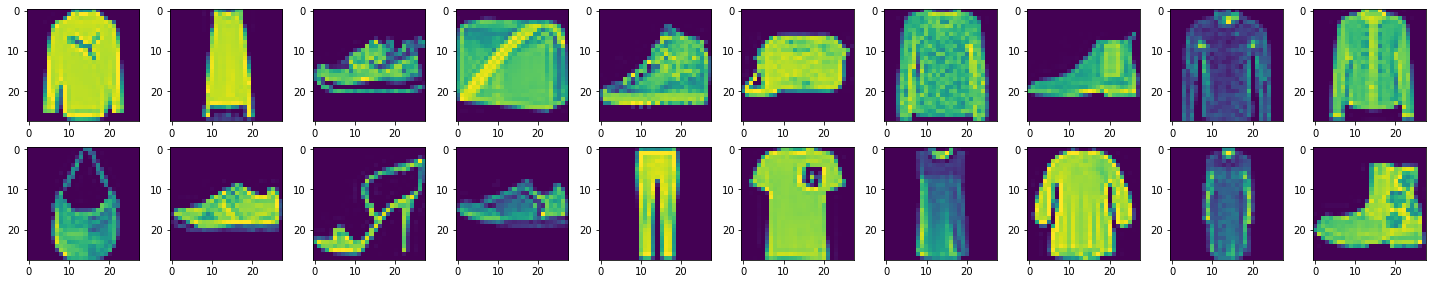

AE 30D


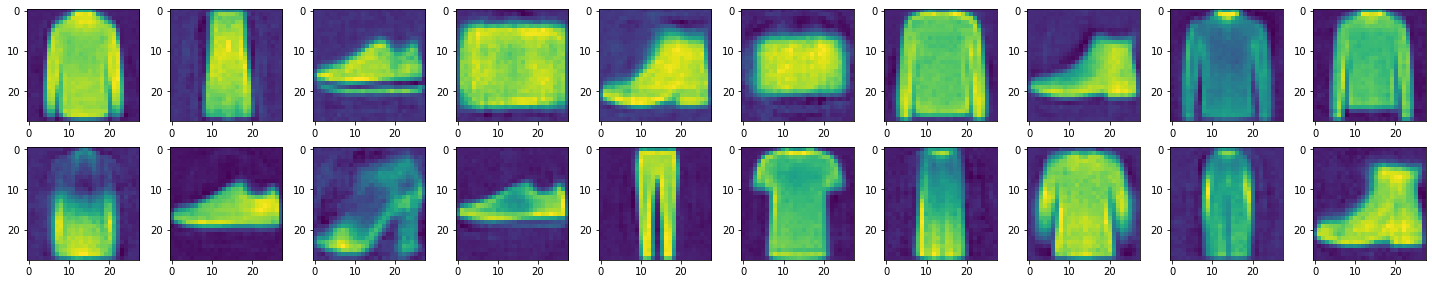

VAE 30D


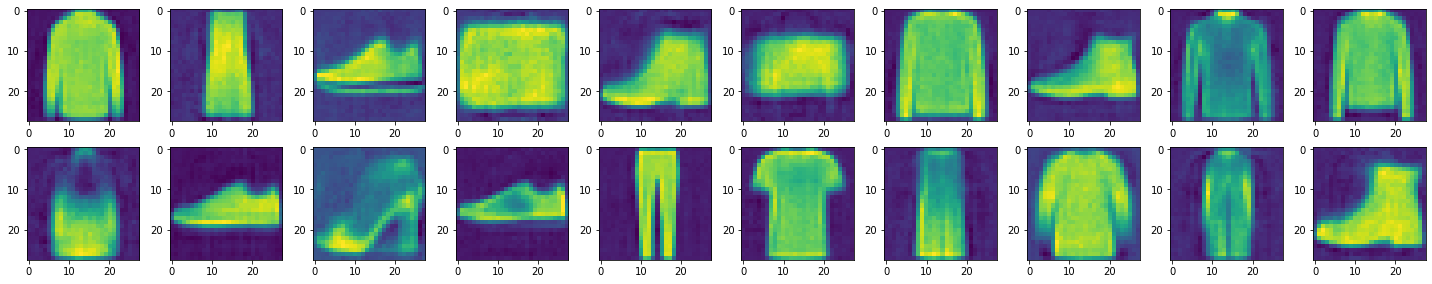

In [56]:
def plot_reconstructions(models, n):
    x = next(iter(test_loader))[0][:n]  # Get a batch and choose `n` of images
    print('Data')
    show(x.squeeze(1))

    x = x.flatten(start_dim=1).to(device)
    for model in models:
        model.eval()
        x_hat, _, _ = model(x)
        print('%s %dD' % (model.type_str, model.z_dim))
        show(x_hat.detach().cpu())
models = [ae, vae]
plot_reconstructions(models, 20)

#interpolation part1
now we want to produce first image that has new features. there is probablity that these features even not exist in train dataset. in this part we want to find the mean of some trouser images in z space and then find mean of some shirt image in z space. then add this means together and give this new z to decoder. we expect that we have Tshirt that has trouser on it.
this is so usefull. consider some images of some faces. mean all the faces that has smile on theire faces and similar thing to all faces that has no smile. then subtract no smile mean in z space from smile faces in z-space. this work gives you the smile in z space. so you can add this smile to every face and make angry face to happy face !!

Data


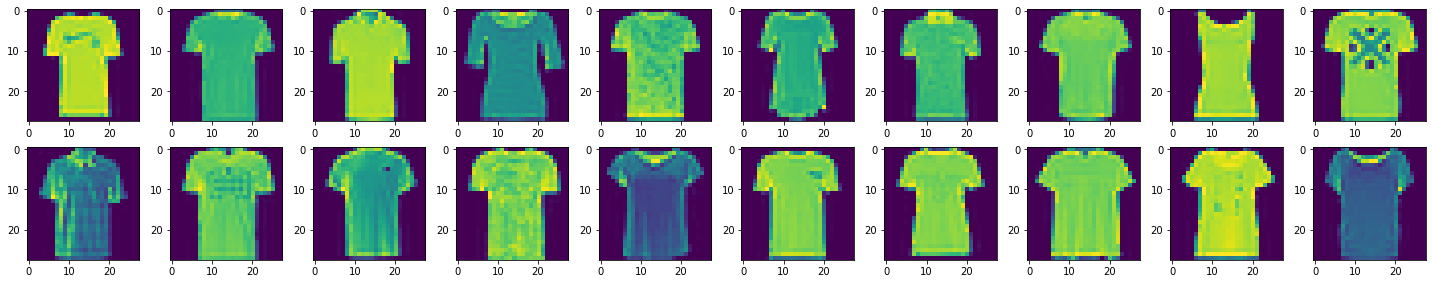

Data


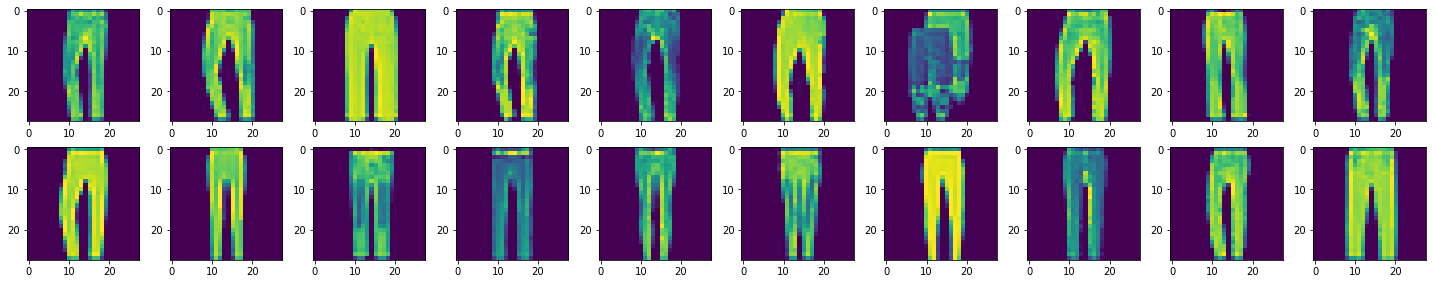

In [51]:
train_dataset = datasets.FashionMNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST('./data', train=False, transform=transforms.ToTensor())
idx = test_dataset.targets == 0
test_dataset.targets = test_dataset.targets[idx]
test_dataset.data = test_dataset.data[idx]
test_loader_trouser = torch.utils.data.DataLoader(test_dataset, **data_loader_kwargs)
x = next(iter(test_loader_trouser))[0][:20]  # Get a batch and choose `n` of images
print('Data')
show(x.squeeze(1))

train_dataset = datasets.FashionMNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST('./data', train=False, transform=transforms.ToTensor())
idx = test_dataset.targets == 1
test_dataset.targets = test_dataset.targets[idx]
test_dataset.data = test_dataset.data[idx]
test_loader_shirts = torch.utils.data.DataLoader(test_dataset, **data_loader_kwargs)
x = next(iter(test_loader_shirts))[0][:20]  # Get a batch and choose `n` of images
print('Data')
show(x.squeeze(1))

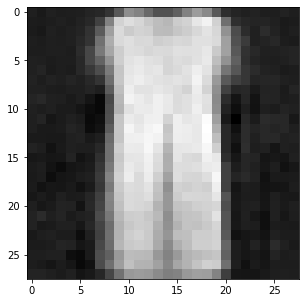

In [52]:
def combine(model, n_rows):
    """
    This function interpolates n_cols images between two random MNIST image
    """
    plt.rcParams['figure.figsize'] = (5, 5)
    x = next(iter(test_loader_trouser))[0][:2 * n_rows].flatten(start_dim=1).to(device)
    y = next(iter(test_loader_shirts))[0][:2 * n_rows].flatten(start_dim=1).to(device)
    shirt_with_trouser = None
    ########################## P15 ###############################
    # use x , y and find mean of trousers and Tshirts in z space #
    # then add theme together in z space and store this value    #
    # in shirt_with_trouser                                      #
    ########################## end ###############################
    x_enc = model.encoder(x)
    y_enc = model.encoder(y)
    mu_x = model.mu_layer(x_enc)
    mu_y = model.mu_layer(y_enc)
    shirt_with_trouser = mu_x + mu_y
    ######################### end ##############################
    img = model.decoder(shirt_with_trouser).cpu().detach()
    img = img.reshape(-1, 28, 28)
    plt.imshow(img[0],cmap = "gray")
vae = vae.to(device)
combine(vae, 128)

#interpolations part 2


AE 30D


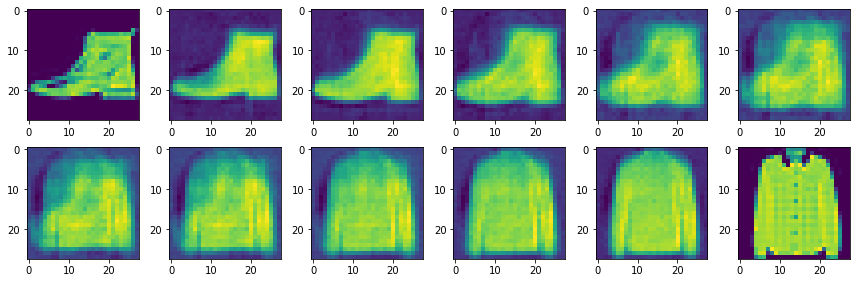

AE 30D


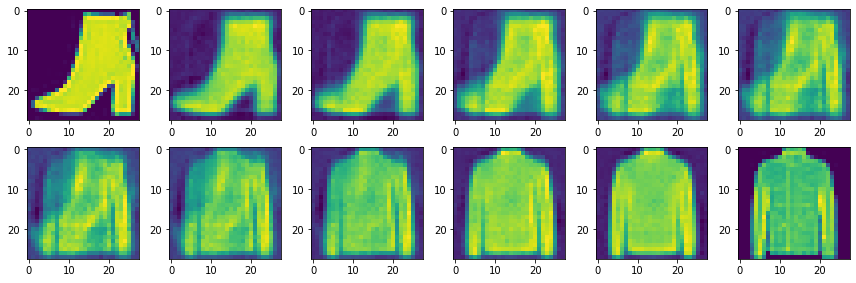

AE 30D


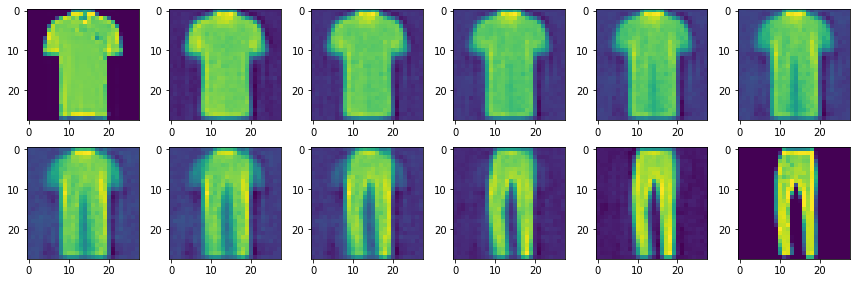

---

VAE 30D


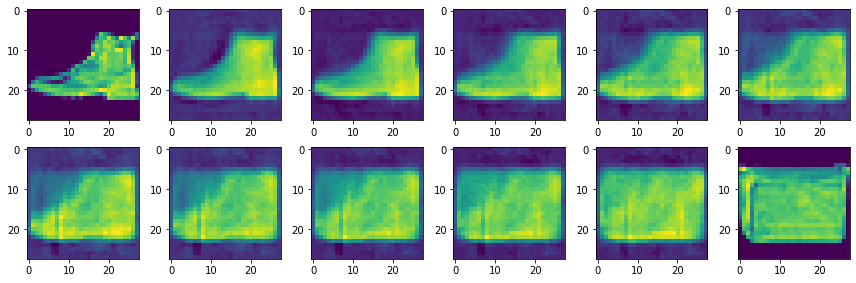

VAE 30D


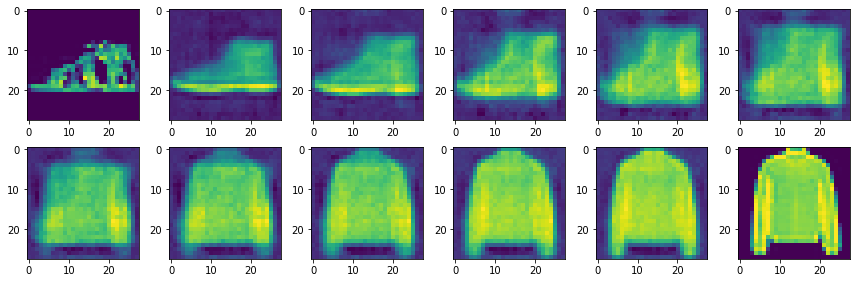

VAE 30D


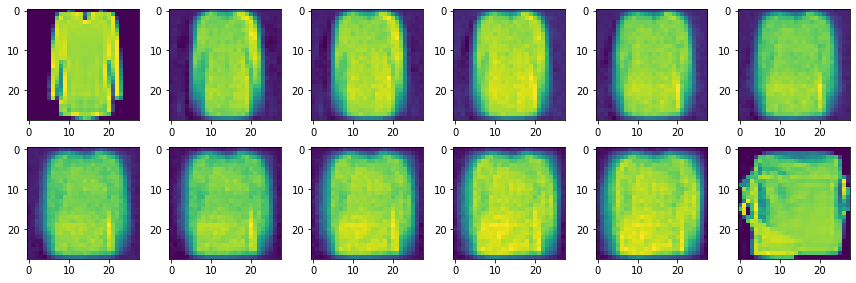

---



In [79]:
from geographiclib.geodesic import Geodesic

def plot_interpolations(model, n_rows, n_cols=10):
    """
    This function interpolates n_cols images between two random MNIST image
    """
    plt.rcParams['figure.figsize'] = (n_cols, n_rows)
    x = next(iter(test_loader))[0][:2 * n_rows].flatten(start_dim=1).to(device)
    for i in range(n_rows):
        img1 = x[2 * i]
        img2 = x[2 * i + 1]
        model.eval()
        images = list()
        ################################ P16 #####################################
        # give your images(img1,img2) to model and get latent value for each     #
        # images.call them z1 and z2. then in z dimension space split the line   #
        # distance between z1 and z2,into n_cols and start to move from z1 to z2 #
        # and find n_cols point between z1 and z2 (in z_dim space). then use     #
        # decoder for new points in z_space and get new image for each point.    #
        # first append img1 to images list then append all new image that        #
        # decoders produced and then append img2 at the end of list.             #
        ##########################################################################
        images.append(img1.cpu().detach())
        
        img1_enc = model.encoder(img1)
        img2_enc = model.encoder(img2)
        if model.type_str == 'AE':
          z1 = model.z_layer(img1_enc)
          z2 = model.z_layer(img2_enc)
    
        if model.type_str == 'VAE':
          mu_img1 = model.mu_layer(img1_enc)
          var_img1 = model.logvar_layer(img1_enc)
          z1 = model.reparameterize(mu_img1, var_img1)
          mu_img2 = model.mu_layer(img2_enc)
          var_img2 = model.logvar_layer(img2_enc)
          z2 = model.reparameterize(mu_img2, var_img2)
         
        # diff = abs(z2 - z1)
        # dist = diff / (n_cols+1)
        for i in range(n_cols):
          new_z = torch.tensor([(torch.lerp(z1[j],z2[j],1./n_cols*i)) for j in range(len(z1))]).to(device)
          img = model.decoder(new_z).cpu().detach()
          # img = img.reshape(-1, 28, 28)
          images.append(img)

        images.append(img2.cpu().detach())
        ################################ end #####################################
        images = torch.stack(images)
        print('%s %dD' % (model.type_str, model.z_dim))
        show(images)
    print('---\n')
plot_interpolations(ae, 3)
plot_interpolations(vae, 3)